# Add Folders to Path

In [1]:
%%time
import sys, os
# get current directory
path = os.getcwd()
# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-3])
# add Algorithm folder to current working path in order to access the functions inside the folder ´Algorithms´
sys.path.append(parent_directory+"/GeneralFunctions")

CPU times: user 116 µs, sys: 79 µs, total: 195 µs
Wall time: 142 µs


# Import Agulhas Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../Data/Agulhas_AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time = mat_file['t']

CPU times: user 137 ms, sys: 46.3 ms, total: 183 ms
Wall time: 183 ms


# Data/Parameters for Dynamical System

In [3]:
%%time
import numpy as np

# Number of cores to be used for parallel computing
Ncores = 18

# Incompressible/Compressible flow. {True, False}
Incompressible = True

# Periodic boundary conditions
periodic_x = False
periodic_y = False
Periodic = [periodic_x, periodic_y]

## Compute Meshgrid
X, Y = np.meshgrid(x, y)

# List of parameters of the flow.
params_data = {"X": X, "Y": Y, "Time": time, "U": U, "V": V, "Ncores": Ncores, 
               "Incompressible": Incompressible, "Periodic": Periodic}

CPU times: user 314 µs, sys: 190 µs, total: 504 µs
Wall time: 322 µs


# Spatio-Temporal Domain of Dynamical System

In [4]:
%%time
# Time
t_OECS = 0

# time as array
time = np.array([t_OECS])

# longitudinal and latitudinal boundaries (in degrees)
xmin = 2
xmax = 7
ymin = -38
ymax = -36

# spacing of meshgrid (in degrees)
dx = 0.01
dy = 0.01

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

params_DS = {"time": time, "X_domain": X_domain, "Y_domain": Y_domain}

# Initialize Dynamical System
from ipynb.fs.defs.DynamicalSystem import *
DS = Dynamical_System(params_data, params_DS)

CPU times: user 354 ms, sys: 83.1 ms, total: 437 ms
Wall time: 436 ms


## Velocity Interpolation

In [5]:
%%time
# Interpolate velocity data using cubic spatial interpolation
DS._Interpolation_velocity("cubic")

CPU times: user 152 ms, sys: 8.76 ms, total: 160 ms
Wall time: 159 ms


# Compute Rate of strain tensor

In [6]:
%%time
from tqdm.notebook import tqdm

S = np.zeros((X_domain.shape[0], X_domain.shape[1], 2, 2))*np.nan


for i in tqdm(range(X_domain.shape[0])):
    
    for j in range(X_domain.shape[1]):
        
        x = np.array([X_domain[i, j], Y_domain[i, j]])
        
        S[i, j,:,:] = DS._spin_tensor(x, t_OECS)

  0%|          | 0/201 [00:00<?, ?it/s]

CPU times: user 35.1 s, sys: 11 s, total: 46.1 s
Wall time: 37 s


# Compute tensorfield properties

In [7]:
from ipynb.fs.defs.tensorfield import _tensorfield

X_domain, Y_domain, s1, s2, v1, v2, S11, S12, S22, S11x, S11y, S12x, S12y, S22x, S22y = _tensorfield(X_domain, Y_domain, S, type = 'OECS')

## Interpolate $ \dot{\phi}(x, y, \phi), s_1(x, y), s_2(x, y) $ 

In [8]:
%%time
from ipynb.fs.defs.phi_prime_OECS import _phi_prime_OECS

# Interpolant phi_phrime
interp_phi_prime = _phi_prime_OECS(X_domain, Y_domain, s1, S11x, S11y, S12x, S12y, S22x, S22y, Ncores)

# Interpolant s_1
from scipy.interpolate import RectBivariateSpline as RBS
interp_s1 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(s1, nan = 1), kx=1, ky=1)

# Interpolant s_2
from scipy.interpolate import RectBivariateSpline as RBS
interp_s2 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(s2, nan = 1), kx=1, ky=1)

CPU times: user 13min 44s, sys: 6.9 s, total: 13min 51s
Wall time: 27.7 s


In [9]:
%%time

from math import atan

PHI = np.zeros(X_domain.shape)*np.nan

for i in tqdm(range(X_domain.shape[0])):
    
    for j in range(X_domain.shape[1]):
    
        if np.isfinite(v1[i, j, 0]):
            v = v1[i, j, :]
            phi = atan(v[1]/v[0])%(2*np.pi)
        
            x = [Y_domain[i, j], X_domain[i, j], phi]
        
            PHI[i, j] = interp_phi_prime(x)

  0%|          | 0/201 [00:00<?, ?it/s]

CPU times: user 21.9 s, sys: 3.69 s, total: 25.6 s
Wall time: 22.4 s


# Find objective Saddle-points (=hyperbolic OECS)

In [10]:
## Initial conditions of repelling LCS are given by fin

In [21]:
from ipynb.fs.defs.loc_max import _loc_max
max_distance = .4

loc_idx_x, loc_idx_y, loc_max_x, loc_max_y, loc_max_field = _loc_max(max_distance, X_domain, Y_domain, s2)

x0s1 = loc_max_x
y0s1 = loc_max_y

  0%|          | 0/17 [00:00<?, ?it/s]

In [22]:
from math import atan, cos, sin

v = v1.copy()
phi0s1 = []

for i in range(len(loc_idx_x)):
    eigenvector = v[loc_idx_y[i], loc_idx_x[i], :]
    phi0s1.append(atan(eigenvector[1]/eigenvector[0])%(2*np.pi))

In [27]:
from scipy.integrate import solve_ivp
from ipynb.fs.defs.tensorline_equation import _tensorline_equation

def launch_trajectories(t, x0, y0, phi0, interp_phi_prime, interp_s, X, Y, defined_domain):
        
        y0 = [x0, y0, phi0]
        
        sol = solve_ivp(_tensorline_equation, t, y0, 'RK45', t_eval, rtol=1e-5, atol=1e-5, args=(interp_phi_prime, interp_s1, X, Y, defined_domain))         
        
        return sol

In [30]:
from ipynb.fs.defs.extract_hyperbolic_OECS import _extract_hyperbolic_OECS

# domain where velocity field is defined
defined_domain = np.isfinite(s2).astype(int)

# define lists containing the position and the rate of attracion/repulsion along 
# unstable/stable segments of the hyperbolic OECS
x_attracting, y_attracting, s_attracting = [], [], []
x_repulsion, y_repulsion, s_repulsion = [], [], []

# Iterate over objective saddle-points (hyperbolic OECS)
for i in tqdm(range(len(x0s1))):
    
    # backward (-1) and forward (+1) integration
    for sign in [-1, 1]:
        
        # define integration interval of dummy variable 's'
        t = [0, sign*5]
        
        # define resolution of stable/unstable segments of hyperbolic OECS
        t_eval = np.linspace(t[0], t[1], 1000)

        # objective saddle-points (hyperbolic OECS)
        x0 = [x0s1[i], y0s1[i], phi0s1[i]]
        
        # solve ODE for unstable segments of thehyperbolic OECS
        sol = solve_ivp(_tensorline_equation, t, x0, 'RK45', t_eval, rtol=1e-5, atol=1e-5, args=(interp_phi_prime, interp_s1, X_domain, Y_domain, defined_domain))         
        # solve ODE for unstable segments of thehyperbolic OECS
        sol = solve_ivp(_tensorline_equation, t, x0, 'RK45', t_eval, rtol=1e-5, atol=1e-5, args=(interp_phi_prime, interp_s1, X_domain, Y_domain, defined_domain)) 
        
        
        # extract attracting/repelling segments from the solution of the ODE as those segments
        # where the rate of attraction/repulsion |s1|=|s2| is monotonically decreasing
        x_attracting_OECS, y_attracting_OECS, s_OECS = _extract_hyperbolic_OECS(sol.y[0,:], sol.y[1,:], interp_s1) 
        
        x_attracting.append(x_attracting_OECS)
        y_attracting.append(y_attracting_OECS)
        s_attracting.append(s_OECS)

  0%|          | 0/14 [00:00<?, ?it/s]

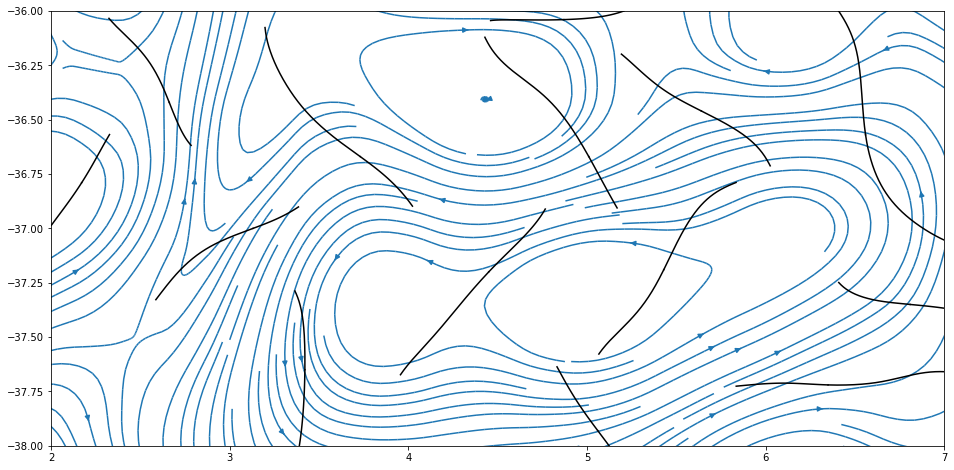

In [35]:
################################ PLOT HYPERBOLIC OECS ################################

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16, 8))
ax = plt.axes()
for i in range(len(x_attracting)):
    ax.plot(x_attracting[i], y_attracting[i], c = "k")
ax.set_xlim(np.min(X_domain), np.max(X_domain))
ax.set_ylim(np.min(Y_domain), np.max(Y_domain))
plt.show()